## Задание1:

* Приведите таблицу в удобный вид (на ваш вкус) и приложите в формате Excel. Не увлекайтесь оформлением, главное - удобство работы с данными.
* Для каждого уровня в обеих когортах посчитайте процент отвала игроков.
* Какие еще сведения способные улучшить игру можно получить из этих данных? Внесите их в вашу таблицу.
* Перед вами стоит выбор - заменить старые 30 уровней новыми, или нет?Почему?

## Задание2:

* Основываясь на данных из таблицы сделайте для лучшей, по вашему мнению,когорты прогноз, какой процент пользователей дойдет до 240, 360, 480, 600 уровня.
* Сколько в среднем уровней на данный момент проходит пользователь? Спрогнозируйте, сколько уровней проходил бы пользователь в среднем, если бы в игре было 240,360,480,600 уровней.
* Предположите, сколько нужно уровней, чтобы снять достоверный Retention D30?

-----

## Загрузка библиотек

In [123]:
import pandas as pd
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings("ignore") 
from tqdm import tqdm_notebook
import os, re, sys, gc

from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from sklearn.linear_model import LinearRegression

In [124]:
# путь к данным
PATH_TO_FILE = r'C:\Users\Sergey\anaconda3\Scripts\ab_test_levels2.xlsx'

## Загрузка данных

In [125]:
# загружаем данные
df = pd.read_excel(PATH_TO_FILE)

In [126]:
df.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,\tFormula,\tUNIQUES(A);TOTALS(A);TOTALS(B);TOTALS(C);TOT...,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,\tA:,\tlevel_start,\tlevel_number,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Подготовка данных
* удалим nan
* соберем шапку таблицы
* заменим значения в колонке Formula
* заменим значения в колонке Segment
* переименуем колонки: [показатель].[характеристика показателя].[статистика]
* разделим на когорты A, B

In [127]:
# удаляем nan
df_notna = df.dropna().reset_index(drop = True)

# названия признаков
colnames = []
for val in df_notna.iloc[0].values:
    try:
        colnames.append(val.strip())
    except:
        colnames.append(val)

df_notna_c = df_notna.drop(0).rename(columns = dict(zip(df_notna.columns, colnames)))
df_notna_c = df_notna_c.astype(str).applymap(lambda val: val.strip()).replace('', np.nan)

# значения в Formula
Formula_unique_values = df_notna_c['Formula'].unique()
Formula_replacements = 'level.start.unique', 'level.start.total', 'level.won.total' ,'level.losed.total', 'level.quit.total'
Formula_d = dict(zip(Formula_unique_values, Formula_replacements))
df_notna_c['Formula'] = df_notna_c['Formula'].map(Formula_d)

# значения в Segment
Segment_unique_values = df_notna_c['Segment'].unique()
Segment_replacements = ['A', 'B']
Segment_d = dict(zip(Segment_unique_values, Segment_replacements))
df_notna_c['Segment'] = df_notna_c['Segment'].map(Segment_d)

# собираем level_number в один столбец
ser_level_number = df_notna_c.rename(columns = {'level_number' : 'level.number'})['level.number'].astype(np.float32).sum(1).astype(int)
df_notna_c = df_notna_c.drop('level_number', 1)
df_notna_c['level.number'] = ser_level_number

df_notna_c = df_notna_c.rename(columns = {df_notna_c.columns[2]:'event/player_total'})

# когорта A
df_A = df_notna_c[df_notna_c['Segment'] == 'A']\
                 .groupby(['Formula', 'level.number'])\
                 ['event/player_total'].sum()\
                 .unstack(0).fillna(0).astype(int)
df_A.columns.name = None

# когорта Б
df_B = df_notna_c[df_notna_c['Segment'] == 'B']\
                 .groupby(['Formula', 'level.number'])\
                 ['event/player_total'].sum()\
                 .unstack(0).fillna(0).astype(int)
df_B.columns.name = None

<code style="background:yellow;color:black">1.1.Приведите таблицу в удобный вид (на ваш вкус) и приложите в формате Excel. Не увлекайтесь оформлением, главное - удобство работы с данными.

In [128]:
df_prepared = pd.concat([df_A.add_suffix('.A'), df_B.add_suffix('.B')], 1)
df_prepared.to_excel('task_1_1.xlsx')

In [129]:
df_prepared.head()

,level.losed.total.A,level.quit.total.A,level.start.total.A,level.start.unique.A,level.won.total.A,level.losed.total.B,level.quit.total.B,level.start.total.B,level.start.unique.B,level.won.total.B
level.number,,,,,,,,,,
1,0,21,1756,1750,1716,0,15,1795,1784,1770
2,0,18,1679,1672,1652,0,12,1734,1725,1715
3,0,30,1621,1602,1587,1,17,1680,1670,1640
4,7,42,1557,1525,1490,0,17,1567,1554,1537
5,4,30,1429,1406,1383,1,10,1475,1471,1457


## Игровой процесс

<img src="matryoshka_pipeline.png">

In [130]:
# кф корреляции
L_corr = []

# датасетов A, B
for flag, df in zip(('A', 'B'), (df_A, df_B)):
    # считаем попраные корреляции для всех признаков
    for i in range(df.shape[1]):
        for j in range(i+1, df.shape[1]):
            col_A, col_B = df.columns[i], df.columns[j]
            ser1, ser2 = df[col_A], df[col_B]
            L_corr.append((flag, col_A, col_B, np.corrcoef(ser1, ser2).min()))  

# финальная таблица
df_corr_AB = pd.DataFrame(L_corr,\
                          columns = ['cohort', 'feature_1', 'feature_2', 'corr_coef'])

# собираем посчитанные корреляции в одну таблицу
L2_corr = []
for (f1, f2), _subdf in df_corr_AB.groupby(['feature_1', 'feature_2']):
    corr1, corr2 = _subdf['corr_coef'].round(4).values.tolist()
    L2_corr.append((f1, f2, corr1, corr2))  

# финальная таблица    
df2_corr_AB = pd.DataFrame(L2_corr,\
                           columns = ['feature_1', 'feature_2', 'corr.A', 'corr.B'])\
                .sort_values('corr.A')\
                .reset_index(drop = True)\
                .set_index(['feature_1', 'feature_2'])

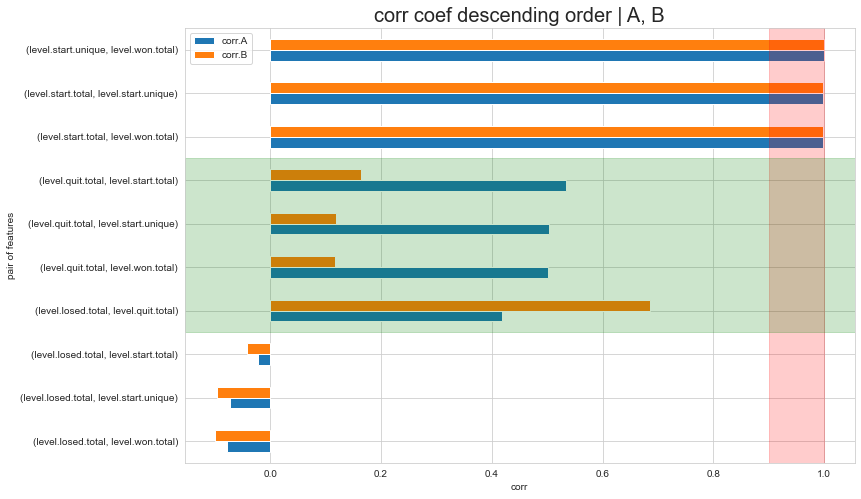

In [131]:
df2_corr_AB.plot(kind = 'barh', figsize = (12, 8))
plt.axvspan(.9, 1, color = 'red', alpha = .2)
plt.axhspan(2.5, 6.5, alpha = .2, color = 'green')
plt.title('corr coef descending order | A, B', fontsize =20)
plt.xlabel('corr')
plt.ylabel('pair of features')
plt.show()

#### Выводы:
* мультиколлинеарные признаки: ['level.start.total', 'level.won.total', 'level.start.unique'] (можно будет оставить один из них)
* пары признаков, корреляция между которыми сильно отличается в A, B

|признак1|признаки2|
|---|---|
|level.quit.total|level.won.total, level.start.unique, level.start.total|
|level.losed.total|level.quit.total, level.start.total|

* значение level.quit.total в когортах A, B различное


<code style="background:yellow;color:black">
1.2. Для каждого уровня в обеих когортах посчитайте процент отвала игроков.
1.3. Какие еще сведения способные улучшить игру можно получить из этих данных? Внесите их в вашу таблицу.

In [132]:
df2_A, df2_B = pd.DataFrame(index = df_A.index).iloc[:-1], pd.DataFrame(index = df_B.index).iloc[:-1]

df_A['level.churn.total'] = df_A['level.start.unique'].diff(-1)
df_B['level.churn.total'] = df_B['level.start.unique'].diff(-1)

df_A['level.churn.rate'] = (df_A['level.start.unique'].diff(-1) / df_A['level.start.unique'].iloc[:-1])
df_B['level.churn.rate'] = (df_B['level.start.unique'].diff(-1) / df_B['level.start.unique'].iloc[:-1])

# масштабируем число уникальных пользователей, чтобы на графике величины были одного масштаба
scaler = MinMaxScaler()
start_unique_A = pd.Series(scaler.fit_transform(df_A[['level.start.unique']]).flatten(), index = df_A.index)
start_unique_B = pd.Series(scaler.fit_transform(df_B[['level.start.unique']]).flatten(), index = df_B.index)

a = min(df_A['level.churn.rate'].min(), df_B['level.churn.rate'].min())
b = max(df_A['level.churn.rate'].max(), df_B['level.churn.rate'].max())
start_unique_into_churn_rate_A = ((b-a)*(start_unique_A- start_unique_A.min())/(start_unique_A.max()-start_unique_A.min()))+a
start_unique_into_churn_rate_B = ((b-a)*(start_unique_B- start_unique_B.min())/(start_unique_B.max()-start_unique_B.min()))+a

# доля поражений
df_A['level.losed.rate'] = df_A['level.losed.total'] /df_A['level.start.total']
df_A['level.quit.rate'] = df_A['level.quit.total'] /df_A['level.start.total']

# доля выходов
df_B['level.losed.rate'] = df_B['level.losed.total'] /df_B['level.start.total']
df_B['level.quit.rate'] = df_B['level.quit.total'] /df_B['level.start.total']

In [133]:
# количество топ значений
N_TOP = 5
# мультипликатор для размера маркеров
MUL = 7

colors_A_B = ('red', 'green')

In [134]:
def _get_feat2_by_top_N_feat1(df_A, feat1, feat2, ascending, n_top):
    '''сортирует по значению feat1 в порядке ascending, выдает n_top значений feat2'''
    return df_A.sort_values(feat1, ascending = ascending).head(n_top)[feat2]

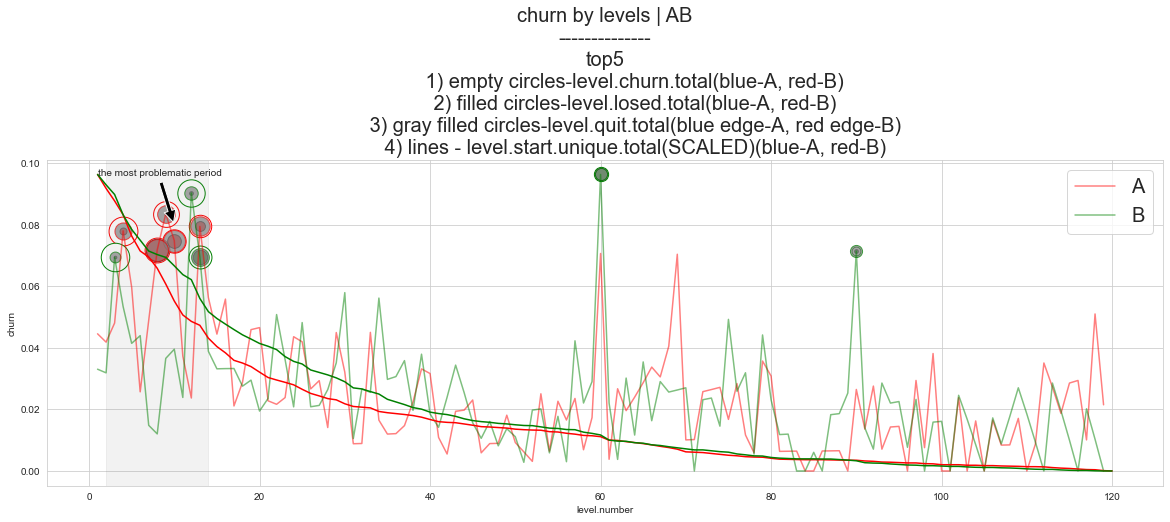

In [135]:
fig, ax = plt.subplots(1, 1, figsize = (20, 6))

# относительный отток в A, B
df_A['level.churn.rate'].plot(ax = ax, color = colors_A_B[0], alpha = .5)
df_B['level.churn.rate'].plot(ax = ax, color = colors_A_B[1], alpha = .5)
plt.title('churn by levels | AB\n--------------\ntop{}\n\
           1) empty circles-level.churn.total(blue-A, red-B)\n\
           2) filled circles-level.losed.total(blue-A, red-B)\n\
           3) gray filled circles-level.quit.total(blue edge-A, red edge-B)\n\
           4) lines - level.start.unique.total(SCALED)(blue-A, red-B)'.format(N_TOP), fontsize = 20)
plt.ylabel('churn')


# топ5 уровней по абсолютному оттоку
for _color, _df in zip(colors_A_B, (df_A, df_B)):    
    for idx, size in _get_feat2_by_top_N_feat1(_df, feat1 = 'level.churn.rate',feat2 = 'level.churn.total',\
                                               ascending = False,n_top = N_TOP).items():
        plt.scatter(idx, _df.loc[idx, 'level.churn.rate'], s = size*MUL, color='white', edgecolor = _color)  
    
# топ5 уровней по числу поражений
for _color, _df in zip(colors_A_B, (df_A, df_B)):  
    for idx, size in _get_feat2_by_top_N_feat1(_df, feat1 = 'level.churn.rate',feat2 = 'level.losed.total',\
                                                   ascending = False,n_top = N_TOP).items():
            plt.scatter(idx, _df.loc[idx, 'level.churn.rate'], s = size*MUL, color=_color, alpha = .7, edgecolor='black')    
            
# топ5 уровней по числу выходов
for _color, _df in zip(colors_A_B, (df_A, df_B)):  
    for idx, size in _get_feat2_by_top_N_feat1(_df, feat1 = 'level.churn.rate',feat2 = 'level.quit.total',\
                                                   ascending = False,n_top = N_TOP).items():
            plt.scatter(idx, _df.loc[idx, 'level.churn.rate'], s = size*MUL, color='gray', alpha = .7, edgecolor=_color)    

# проблемный отрезок
plt.axvspan(2, 14, alpha = .1, color = 'gray')    


plt.annotate('the most problematic period', xy=(10, .08), xytext=(1, .096),\
             arrowprops=dict(facecolor='black', shrink=0.05))

# число уникальных пользователей
start_unique_into_churn_rate_A.plot(ax = ax, color =colors_A_B[0]) 
start_unique_into_churn_rate_B.plot(ax = ax, color =colors_A_B[1])

plt.legend(['A', 'B'], fontsize =20)

plt.show()

In [136]:
D = {}
L_dfs = []
for feature in ('level.losed.rate', 'level.quit.rate', 'level.churn.rate'):
    empty_df = pd.DataFrame()
    top5_churn_levels_A = df_A.sort_values(feature, ascending = False).head(N_TOP).sort_index()[feature]
    top5_churn_levels_B = df_B.sort_values(feature, ascending = False).head(N_TOP).sort_index()[feature]
    for k, v in top5_churn_levels_A.items():
        empty_df.loc[k, 'A'] = v
    for k, v in top5_churn_levels_B.items():
        empty_df.loc[k, 'B'] = v
        
    
    empty_df = empty_df.sort_index().iloc[::-1]   
    empty_df.index.name = feature+'.top'+str(N_TOP)
    L_dfs.append(empty_df.fillna(0))

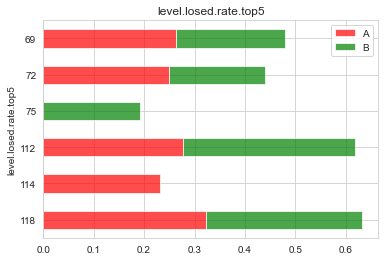

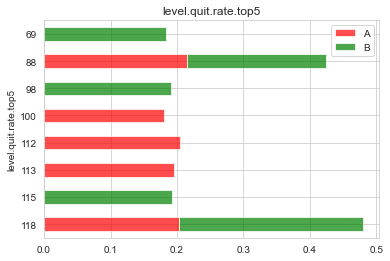

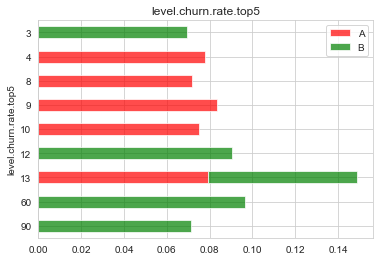

In [139]:
for df in L_dfs:
    df.plot(kind = 'barh', stacked = True, color=colors_A_B, alpha = .7)
    plt.title(df.index.name)    

#### Выводы:
* игроки обеих когорт уходят/проигрывают чаще всего в начале игры (до 13 уровня). ситуация особенно плоха в когорте А. это говрит о том, что эти уровни слишком сложные
* на первых 3 уровнях есть отток игроков без поражения (когорта А)- это говорит отом,что уровни скучные. в когорте Б такая ситуация не наблюдается
* чаще всего игроки прерывают прохождение уровня после чекпоинтов(середина, конец игры). данные уровни являются "боссами", игроки устают-->прерывают игру.
* на 59 уровне из обеих когорт уходит идентичная доля игроков, то есть далее изменения в уровнях незначительно влияют на удержание. 
* уровни когорты B лучше сформированы, чем уровни когорты A

<code style="background:yellow;color:black">1.4.Перед вами стоит выбор - заменить старые 30 уровней новыми, или нет?Почему?
исходя из проведенного анализа, стоит заменить старые 30 урвоней на новые, потому что они лучше удерживают игроков, являются менее скучными в самом начале

<code style="background:yellow;color:black">2.1.Основываясь на данных из таблицы сделайте для лучшей, по вашему мнению,когорты прогноз, какой процент пользователей дойдет до 240, 360, 480, 600 уровня.

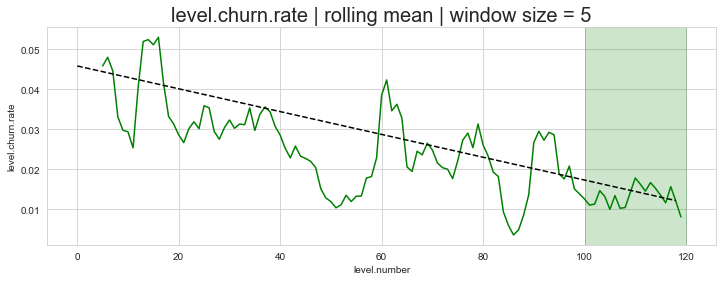

In [197]:
churn_rate_B = df_B['level.churn.rate'].dropna()
churn_rate_rolling_5_B = churn_rate_B.rolling(5).mean()
churn_rate_rolling_5_B.plot(color = 'green', figsize = (12, 4))
plt.plot(np.linspace(churn_rate_rolling_5_B.iloc[:5].mean(), churn_rate_rolling_5_B.iloc[-5:].mean(), len(churn_rate_rolling_5_B)),\
         linestyle ='--', color ='black')
plt.axvspan(100, 120, color='green', alpha = .2)
plt.title('level.churn.rate | rolling mean | window size = 5', fontsize = 20)
plt.ylabel('level.churn.rate')
plt.show()

#### Выводы:
* актуальным периодом для прогнозирования является период с примерно 100-го уровня(на данном этапе скачки прекращабтся и отток выходит на полку)

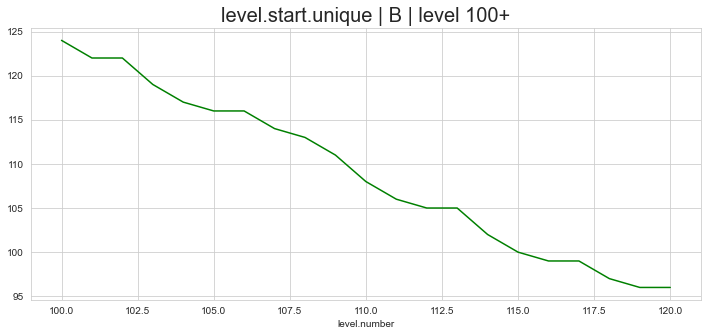

In [207]:
to_forecast_B = df_B.loc[100:, 'level.start.unique']
to_forecast_B.plot(color ='green', figsize = (12, 5))
plt.title('level.start.unique | B | level 100+', fontsize = 20)
plt.show()

In [232]:
# линейная регрессия
lr = LinearRegression()
# лучшее значение метрики качества
best_MAE = np.inf
# выбрасываем первые N наблюдений
for N in range(11):
    
    # индекс, значение
    x, y = to_forecast_B.index.values[N:], to_forecast_B.values[N:]    
    # фитим регрессию на всех значениях, кроме последнего
    lr.fit(x[:-1].reshape(-1, 1), y[:-1].reshape(-1, 1))
    # делаем предсказание для последнего
    prediction = lr.predict(x[-1].reshape(-1, 1)).flatten()[0]
    # считаем амбсолютную ошибку 
    MAE = np.abs(prediction  - y[-1])
    if MAE < best_MAE:
        best_MAE = MAE
        best_x = x
        best_y = y

In [242]:
lr.fit(best_x.reshape(-1, 1), best_y.reshape(-1, 1))

LinearRegression()

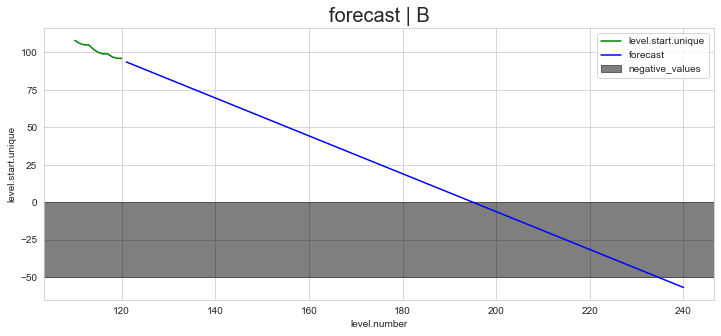

In [274]:
plt.figure(figsize = (12, 5))
plt.plot(best_x, best_y, color='green')
x_pred = np.arange(121, 241).reshape(-1,1)
y_pred = pd.Series(lr.predict(x_pred).flatten(), index = x_pred.flatten())
y_pred.plot(color ='blue')
plt.axhspan(-50, 0, color ='black', alpha = .5)
plt.legend(['level.start.unique', 'forecast', 'negative_values'])
plt.title('forecast | B', fontsize = 20)
plt.ylabel('level.start.unique')
plt.xlabel('level.number');

<code style="background:yellow;color:black">2.2. Сколько в среднем уровней на данный момент проходит пользователь? Спрогнозируйте, сколько уровней проходил бы пользователь в среднем, если бы в игре было 240,360,480,600 уровней.

In [294]:
df_winrate_AB = pd.DataFrame()
df_winrate_AB.loc['A', 'winrate.mean'] = (df_A['level.won.total'] / df_A['level.start.total']).mean()
df_winrate_AB.loc['B', 'winrate.mean'] = (df_B['level.won.total'] / df_B['level.start.total']).mean()


In [306]:
df_winrate_AB

,winrate.mean
A,0.926559
B,0.925636


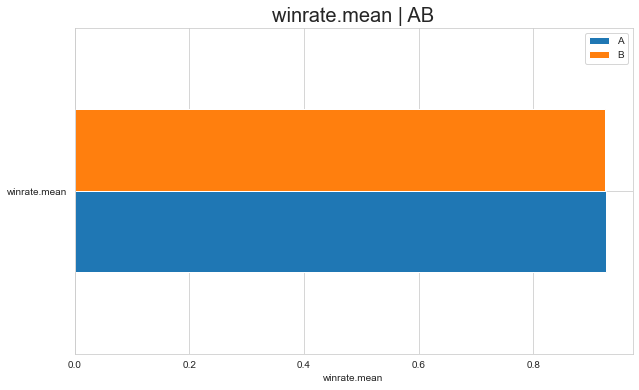

In [307]:
df_winrate_AB.T.plot(kind = 'barh', figsize = (10, 6))
plt.title('winrate.mean | AB', fontsize = 20)
plt.xlabel('winrate.mean')
plt.show()

#### Выводы:
* винрейты в когортах А и B примерно одинаковые(~92%)
